In [1]:
#!pip install opencv-python --user

In [2]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, utils
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import matplotlib as mpl
import cv2
import os, sys, tarfile, time, logging

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


### Define functions

In [3]:
def  visualize(img_arr):
    plt.imshow(img_arr)
    plt.axis('off')
    

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    #print('aaaaa = {}'.format(((pred > 0.5) == label)*1.))
    corr = ((pred > 0.5) == label)*1.
    #print('corr = {}'.format(corr.mean()))
    return (((pred > 0.5) == label)*1.).mean()
metric = mx.metric.CustomMetric(facc)

### Parameters

In [4]:
batch_size = 100
latent_z_size = 100

data_path = 'mnist'
context = mx.gpu()

epochs = 200
disc_study_rate = 1
log_freq = 1

lr = .0002
beta1 = 0.5


### Load Data

In [5]:
# Fixing the random seed
#mx.random.seed(42)
mnist = mx.test_utils.get_mnist()


### 28 * 28 image iterator
t = np.array([(x-0.5)*2 for x in mnist['train_data']])
train_data = mx.io.NDArrayIter(t, mnist['train_label'], batch_size, shuffle=True, last_batch_handle = 'discard')

### Print 28 * 28 image

INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1431: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(flbl.read(), dtype=np.int8)
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
/opt/venv/lib/python3.6/site-packages/mxnet/test_utils.py:1434: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download


DEBUG:matplotlib.font_manager:findfont: Matching :family=NanumGothicCoding:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to NanumGothicCoding ('/usr/share/fonts/truetype/nanum/NanumGothic_Coding.ttf') with score of 0.050000


(28, 28)
(28, 28)
(28, 28)


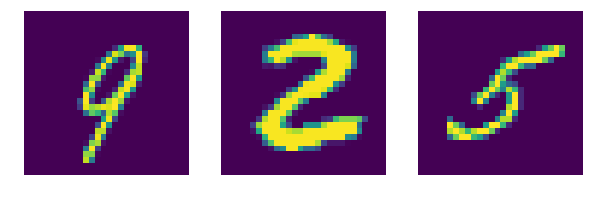

In [6]:
plt.figure(figsize=(10,10))
for i, j in enumerate(np.random.choice(range(100), 3)):
    plt.subplot(1,3,i+1)
    print(mnist['train_data'][j + 10][0].shape)
    visualize(mnist['train_data'][j + 10][0])
plt.show()

In [7]:
latent_dim = 64
class Gen(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Gen, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = nn.Dense(128)
            self.dense2 = nn.Dense(256)
            self.dense3 = nn.Dense(784)
            self.bn1 = nn.BatchNorm()
            self.bn2 = nn.BatchNorm()
            
    def hybrid_forward(self, F, x):
        x = self.dense1(x)
        x = self.bn1(x)
        x = nd.relu(x)
        #print('x1.shape = {}'.format(x.shape))
        x = self.dense2(x)
        x = self.bn2(x)
        x = nd.relu(x)
        x = self.dense3(x)
        x = nd.tanh(x)
        return x

In [8]:
# build the generator
#nc = 1
#ngf = 32
#gen = nn.Sequential()
#with gen.name_scope():
#    # input is Z, going into a convolution
#    gen.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
#    gen.add(nn.BatchNorm())
#    gen.add(nn.Activation('relu'))
#    # state size. (ngf*8) x 4 x 4
#    gen.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
#    gen.add(nn.BatchNorm())
#    gen.add(nn.Activation('relu'))
#    # state size. (ngf*4) x 8 x 8
#    gen.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
#    gen.add(nn.BatchNorm())
#    gen.add(nn.Activation('relu'))
#    # state size. (ngf*2) x 16 x 16
#    gen.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
#    gen.add(nn.BatchNorm())
#    gen.add(nn.Activation('relu'))
#    # state size. () x 32 x 32
#    gen.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
#    gen.add(nn.Activation('sigmoid'))
#    # state size. (nc) x 64 x 64

## NOTE

### What I did
* Added Batch normalization
* Put .2 in LaekyRelu layer


### Important
* Batch normalization is important

### Mode Collapse Problem

* To check if there is model collapse problem I need to print multiple figures

### Define disc

In [9]:
class Disc(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Disc, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = nn.Dense(128)
            self.dense2 = nn.Dense(64)
            self.dense3 = nn.Dense(1)
            self.bn1 = nn.BatchNorm()
            self.bn2 = nn.BatchNorm()
            self.leaky1 = nn.LeakyReLU(.01)
            self.leaky2 = nn.LeakyReLU(.01)
            
    def hybrid_forward(self, F, x):
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.leaky1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.leaky2(x)
        x = self.dense3(x)
        return x

## Start training

In [10]:

#gen = Gen()
disc = Disc()
gen.collect_params().initialize(mx.init.Normal(0.02), ctx = context)
disc.collect_params().initialize(mx.init.Normal(0.02), ctx = context)

loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
gen_trainer = gluon.Trainer(gen.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
disc_trainer = gluon.Trainer(disc.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

NameError: name 'gen' is not defined

In [ ]:
#define loss metric
real_label = nd.ones((batch_size,), ctx=context)
fake_label = nd.zeros((batch_size,),ctx=context)

In [ ]:
# test에서 항상 뽑아볼 수 있는 고정된 z를 사전에 뽑아둡니다.
latent_dim = 64
fixed_z = nd.random.uniform(shape = (16, latent_dim), ctx = context)

## NOTE

* I added Batch Normalization
* Normalize data: -1 < x < 1

In [ ]:
# %matplotlib inline
iter_loss = dict()
iter_loss['disc'] = []
iter_loss['gen'] = []


for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    n_data = 0
    for batch in train_data:
        # Reshape data
        ## Discriminator error
        data = batch.data[0].as_in_context(context)
        latent_z = nd.random.uniform(0, 1, shape =(batch_size, latent_dim), ctx = context)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        with autograd.record():
            #print('data reshape = {}'.format(data.reshape((-1, 28 * 28)).shape))
            # real error
            out_real = disc(data.reshape((-1, 28 * 28))).reshape((-1, 1))
            d_err_real = loss(out_real, real_label)
            metric.update([real_label,], [out_real,])
            # fake error
            fake = gen(latent_z)
            #print('fake reshape = {}'.format(fake.shape))
            out_fake = disc(fake.detach()).reshape((-1, 1)) # Generator 고정시키기
            d_err_fake = loss(out_fake, fake_label)
            d_err = d_err_real + d_err_fake
            d_err.backward()
            metric.update([fake_label,], [out_fake,])
            #print('d_err = {}'.format(d_err))
        disc_trainer.step(batch_size)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = gen(latent_z)
            #print('fake size = {}'.format(fake.shape))
            out = disc(fake).reshape((-1, 1))
            #print('out size = {}'.format(out.shape))
            g_err = loss(out, real_label)
            g_err.backward()
        gen_trainer.step(batch_size)
        n_data += data.shape[0]
    
        iter += 1
        
        #if iter % 100 == 0:
        #    gen_img = gen(fixed_z[:1, :])
        #    print(gen_img.asnumpy().reshape((28, 28)).shape)
        #    plt.imshow(gen_img.asnumpy().reshape((28, 28))) #Needs to be in row,col order
        #    plt.show()

    #save dis/gen loss
    if epoch % log_freq == 0:
        name, acc = metric.get()
        logging.info('speed: {} samples/s'.format(n_data / (time.time() - btic)))
        logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at epoch %d'
                            %(nd.mean(d_err).asscalar(),
                            nd.mean(g_err).asscalar(), acc, epoch))
        iter_loss['disc'].append(nd.mean(d_err).asscalar())
        iter_loss['gen'].append(nd.mean(g_err).asscalar())
        gen_img = gen(fixed_z)
        plt.figure(figsize=(10,10))
        for i in range(8):
            plt.subplot(1,8,i+1)
            plt.imshow(gen_img[i].asnumpy().reshape((28, 28)), cmap='Greys_r')
            plt.axis('off')
        plt.show()
    name, acc = metric.get()
    metric.reset()

In [ ]:
        plt.figure(figsize=(10,10))
        for i in range(16):
            plt.add_subplot(4,4,i+1)
            print(i)
            #plt.imshow(gen_img[i][0].asnumpy(), cmap='gray')
            plt.imshow((gen_img[i][0].asnumpy() +1)*127.5,cmap='gray')
            plt.axis('off')
        plt.show()